In [1]:
import os
import json
import requests
import pandas as pd
import prettytable
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import numpy as np


In [2]:
key_df=pd.read_csv('/Users/Houston Miller/Documents/api_keys.csv')
BLS_ENDPOINT = "https://api.bls.gov/publicAPI/v2/timeseries/data/"

In [3]:
#key_df.loc[key_df['API'] == 'bls', 'KEY'].item()
BLS_API_KEY = key_df.columns[0]
BLS_ENDPOINT = "https://api.bls.gov/publicAPI/v2/timeseries/data/"

def fetch_bls_series(series, **kwargs):
    """
    Pass in a lost of BLS series IDs, Arguments can be provided as kwargs
        - startyear (4 digit year)
        - endyear (4 digit year)
        - catalog (True/False)
        - calculations (True/False)
        - annualaverage (True/False)
        - registrationKey (API key)       
    """

    if len(series) < 1 or len(series) > 50:
        raise ValueError("Series list must be between 1 and 50 series IDs")
    # create headers and payload POST request
    headers = {'Content-Type': 'application/json'}
    payload = {
        "seriesid": series,
        "registrationKey": BLS_API_KEY
    }
    # add kwargs to payload
    payload.update(kwargs)
    payload = json.dumps(payload)
    # make the request
    response = requests.post(BLS_ENDPOINT, data=payload, headers=headers)
    response.raise_for_status()

    result = response.json()
    if result.get('status') != 'REQUEST_SUCCEEDED':
        error_message = f"BLS API Error: Status - {result.get('status', 'UNKNOWN')}"
        if result.get('message'):
            error_message += f". Messages: {', '.join(result['message'])}"
        raise Exception(error_message)
    return result

In [ ]:
#series = ['TUU10101AA01013585','TUU10101AA01014236','TUU10101AA01013951','TUU10101AA01042892','TUU10101AA01009381','TUU10101AA01000865', 'TUU10101AA01001102','TUU20101AA01002864',]
series = ['CES0000000001','CES3000000001','CES0500000001','CES9000000001','CES0500000003','SUUR0000SAF11','SUUR0000SEFV','SUUR0000SAH','SUUR0000SAH1','SUUR0000SAA','SUUR0000SAR','EIUIR','EIUIR0','EIUIR4',]
#series = ['CUURS12BSAC','CUURS12BSACL11','CUURS12BSAF','CUURS12BSAF1','CUURS12BSAF11','CUURS12BSAF112','CUURS12BSAF113','CUURS12BSAF116','CUURS12BSEFJ','CUURS12BSEFV','CUURS12BSEHA','CUURS12BSEHC','CUURS12BSEHC01','CUUSS12BSACL11','CUUSS12BSAF','CUUSS12BSAF1','CUUSS12BSAF11','CUUSS12BSAF112','CUUSS12BSAF113','CUUSS12BSAF115','CUUSS12BSAF116','CUUSS12BSAH']
api_response_dict = fetch_bls_series(series, startyear='2017', endyear='2023')

if api_response_dict:
    print(json.dumps(api_response_dict, indent=2))
#json_data = print(json.dumps(json_data, indent=2))
#print(json.loads(json_data))

{
  "status": "REQUEST_SUCCEEDED",
  "responseTime": 349,
  "message": [],
  "Results": {
    "series": [
      {
        "seriesID": "CES0000000001",
        "data": [
          {
            "year": "2023",
            "period": "M12",
            "periodName": "December",
            "value": "156930",
            "footnotes": [
              {}
            ]
          },
          {
            "year": "2023",
            "period": "M11",
            "periodName": "November",
            "value": "156661",
            "footnotes": [
              {}
            ]
          },
          {
            "year": "2023",
            "period": "M10",
            "periodName": "October",
            "value": "156520",
            "footnotes": [
              {}
            ]
          },
          {
            "year": "2023",
            "period": "M09",
            "periodName": "September",
            "value": "156334",
            "footnotes": [
              {}
            ]
        

In [5]:
try:
    #create a list to store individual dataframes
    dfs = []

    for series in api_response_dict['Results']['series']:
        df_initial = pd.DataFrame(series)
        series_col = df_initial['seriesID'][0]

        for i in range(0, len(df_initial) - 1):
            df_row = pd.DataFrame(df_initial['data'][i])
            df_row['seriesID'] = series_col

            if 'code' not in str(df_row['footnotes']):
                df_row['footnotes'] = ''
            else:
                df_row['footnotes'] = str(df_row['footnotes']).split("'code': '", 1)[1][:1]

            # Append df_row to the list of dataframes
            dfs.append(df_row)

    # Concatenate all dataframes in the list into a single dataframe
    df = pd.concat(dfs, ignore_index=True)

    #save the dataframe to a CSV file
    df.to_csv('bls_data.csv', index=False)

except Exception as e:
    api_response_dict['status'] == 'REQUEST_NOT_PROCESSED'
    print('BLS API Error: Status - ', api_response_dict['status'])
    print('Reason:', api_response_dict['message'])
    print('Error:', str(e))

In [ ]:
#2020 data is not available
df_filtered = df[df['year'] != '2020']

df = df_filtered

df

In [ ]:
#Specify the correct format for the 'date' column
df['date'] = df['year'].astype(str) + ' ' + df['period']

#convert 'date' column to datetime type with the correct format
df['date'] = pd.to_datetime(df['date'], format='%Y M%m')

#convert 'value' column to numeric (handling non-numeric values)
df['value'] = pd.to_numeric(df['value'], errors='coerce')

#Replace NaN values with a default value (e.g., 0) or handle them based on use case
df['value'] = df['value'].fillna(0)

#convert 'value' column to integers and then round to specified number of decimal places
decimal_places = 2
df['value'] = df['value'].astype(int).round(decimal_places)

#sort dataframe by the 'date' column
df = df.sort_values('date')

#iterate through unique 'seriesID' values for legend
#for series_id, series_name in zip(df['seriesID']).unique(), dataset['Config Name'].unique()):
    #series_data = df[df['seriesID'] == series_id]
    #plt.plot(series_data['date'], series_data['value'], label=series_name)

#customize the plot
plt.title('test')
plt.xlabel('year')
plt.ylabel('Int Value (Rounded)')
plt.legend()
plt.grid(True)
plt.show()

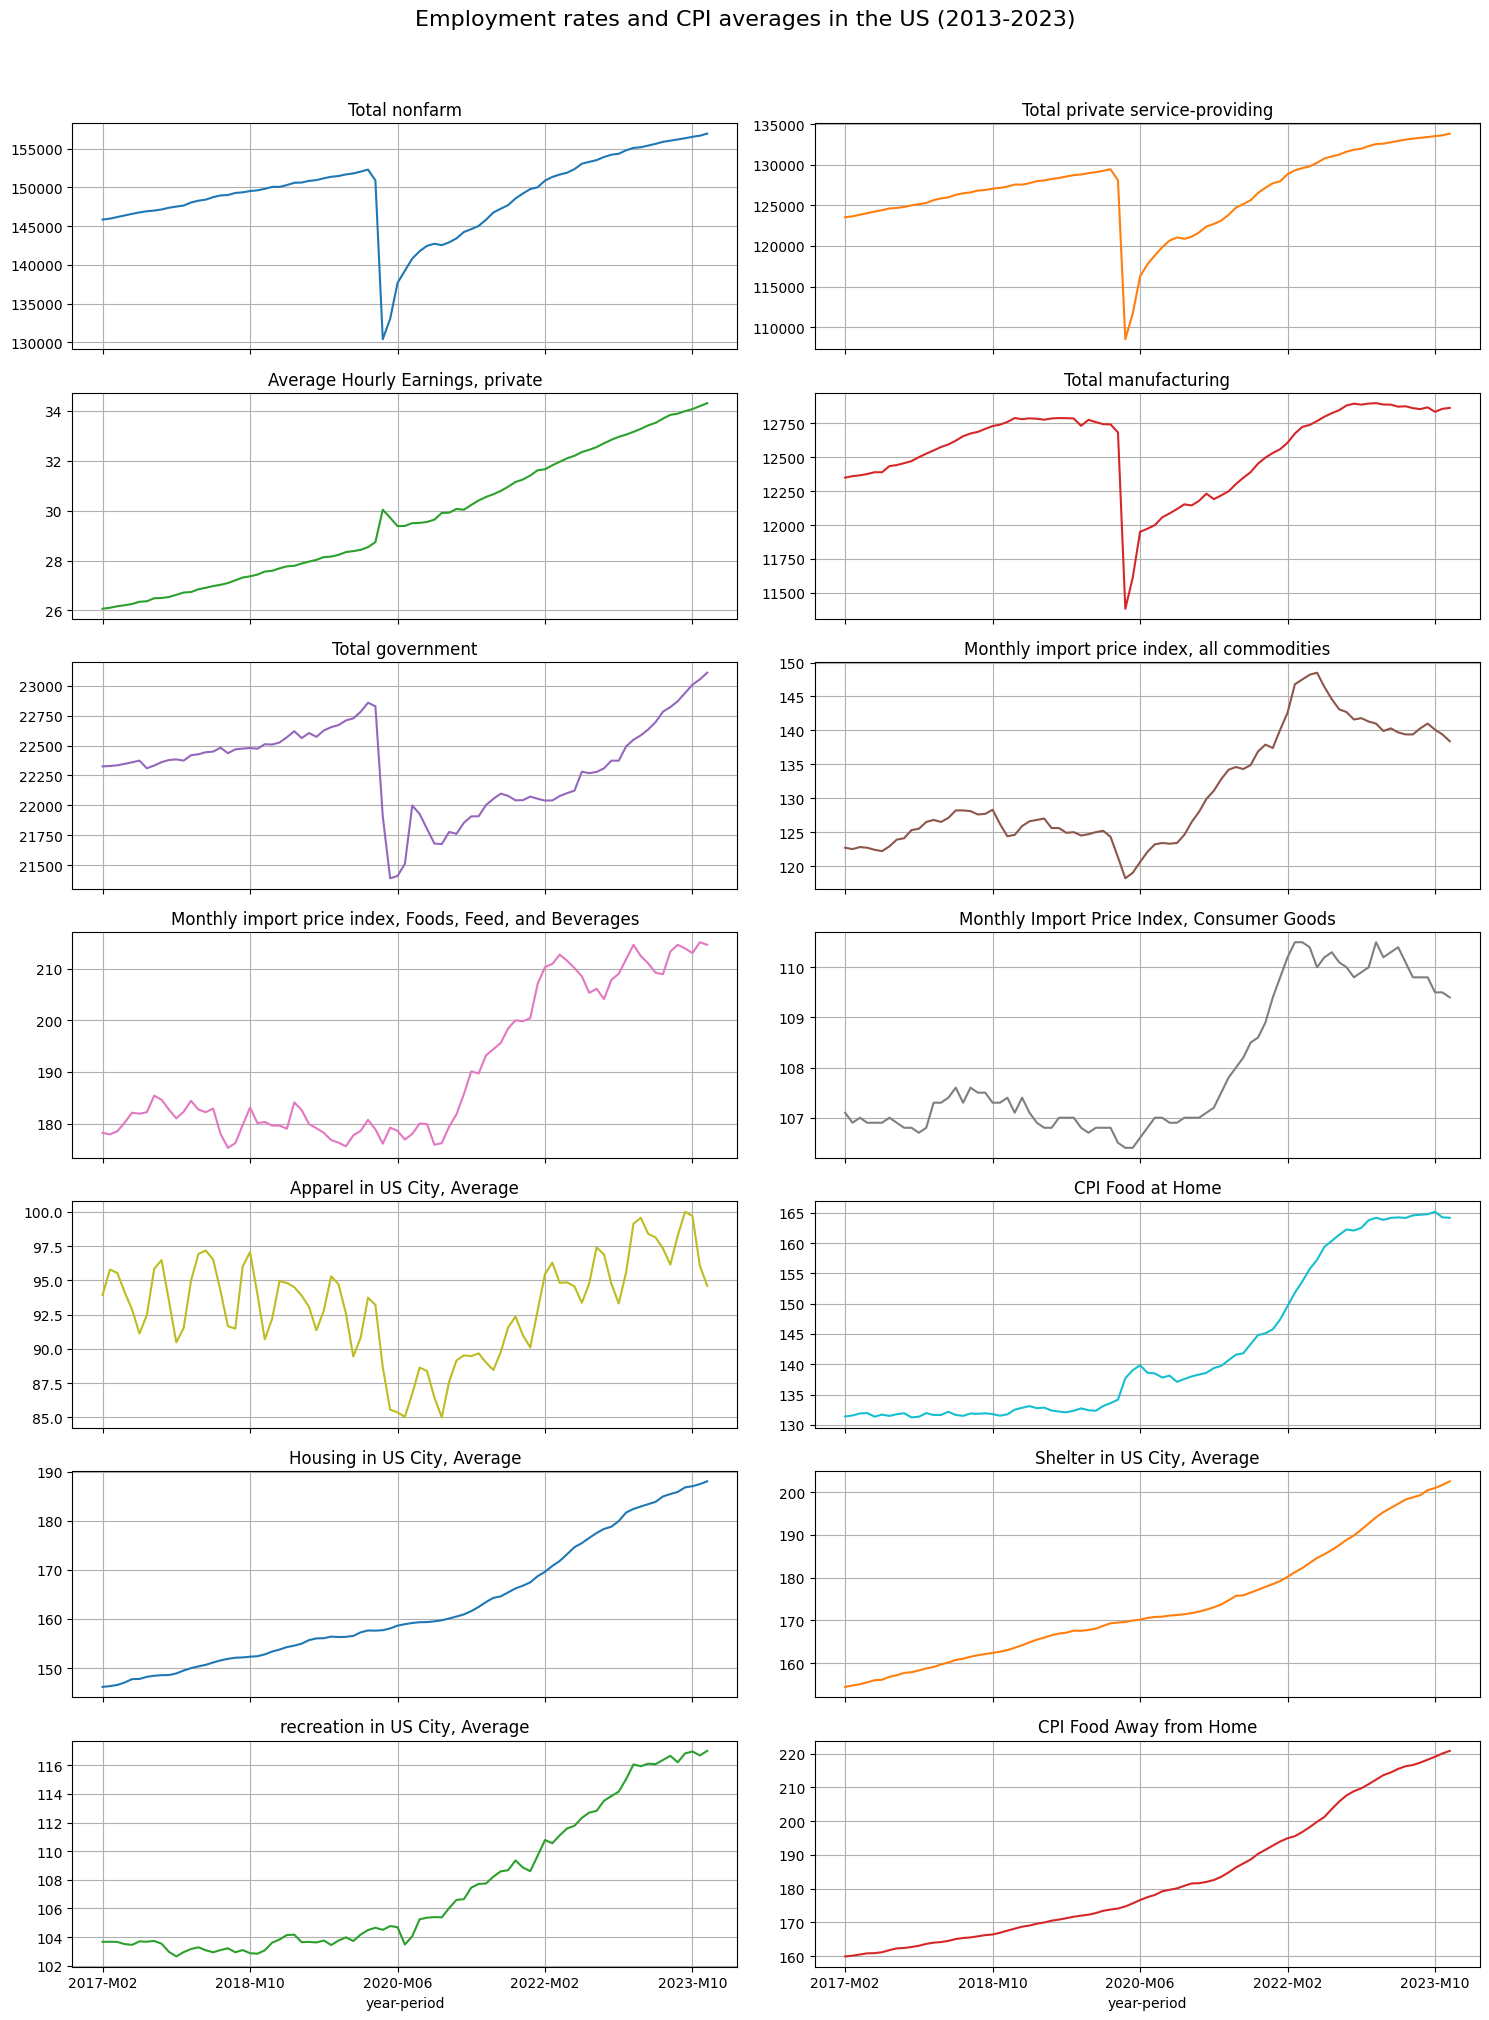

In [6]:
seriesID_to_name = {
    'CES0000000001': 'Total nonfarm',
    'CES3000000001': 'Total manufacturing',
    'CES0500000001': 'Total private service-providing',
    'CES9000000001': 'Total government',
    'CES0500000003': 'Average Hourly Earnings, private',
    'SUUR0000SAF11': 'CPI Food at Home',
    'SUUR0000SEFV': 'CPI Food Away from Home',
    'SUUR0000SAH': 'Housing in US City, Average',
    'SUUR0000SAH1': 'Shelter in US City, Average',
    'SUUR0000SAA': 'Apparel in US City, Average',
    'SUUR0000SAR': 'recreation in US City, Average',
    'EIUIR': 'Monthly import price index, all commodities',
    'EIUIR0': 'Monthly import price index, Foods, Feed, and Beverages',
    'EIUIR4': 'Monthly Import Price Index, Consumer Goods',
    
    # 'TUU10101AA01013585': 'Average HPD leisure and sports',
    # 'TUU10101AA01014236': 'Average HPD Watching TV',
    # 'TUU10101AA01013951': 'Average HPD Socializing and communicating',
    # 'TUU10101AA01042892': 'Average HPD Care/Helping children',
    # 'TUU10101AA01009381': 'Average HPD Household activities',
    # 'TUU10101AA01000865': 'Average HPD Housework',
    # 'TUU10101AA01001102': 'Food preparation and cleanup',
    # 'TUU20101AA01002864': 'Average HPD Working, Employed'
}

df['year'] = pd.to_numeric(df['year'])
df['value'] = pd.to_numeric(df['value'])
df['year-period'] = df['year'].astype(str) + '-' + df['period']

df_wide = df.pivot(index='year-period', columns='seriesID', values='value')

df_wide = df_wide.sort_index()
df_wide = df_wide.rename(columns=seriesID_to_name)

#average_monthly_values = df_wide.mean().sort_values(ascending=False)

# df_wide.plot(kind='line', figsize=(15,8))
# plt.title('Employment rates and CPI averages in the US (2013-2023)')
# plt.xlabel('Series')
# plt.ylabel('Average Monthly Value')
# plt.xticks(rotation=45, ha='right')
# #plt.legend(title='seriesID', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

num_series = len(df_wide.columns)
num_cols = 2
num_rows = (num_series + num_cols - 1) // num_cols

df_wide.plot(
    kind='line',
    subplots=True,
    figsize=(15, 3 * num_rows),
    layout=(num_rows, num_cols),
    sharex=True,
    grid=True,
    legend=False,
    title=[name for name in df_wide.columns]
)
plt.suptitle('Employment rates and CPI averages in the US (2013-2023)', fontsize=16, y=0.99)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust layout to make room for the title
plt.show()

In [ ]:
num_series = len(df_wide.columns)
num_cols = 2
num_rows = (num_series + num_cols - 1) // num_cols

df_wide.plot(
    kind='line',
    subplots=True,
    figsize=(15, 3 * num_rows),
    layout=(num_rows, num_cols),
    sharex=True,
    grid=True,
    legend=False,
    title=[name for name in df_wide.columns]
)
plt.suptitle('test', fontsize=16, y=0.99)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust layout to make room for the title
plt.show()

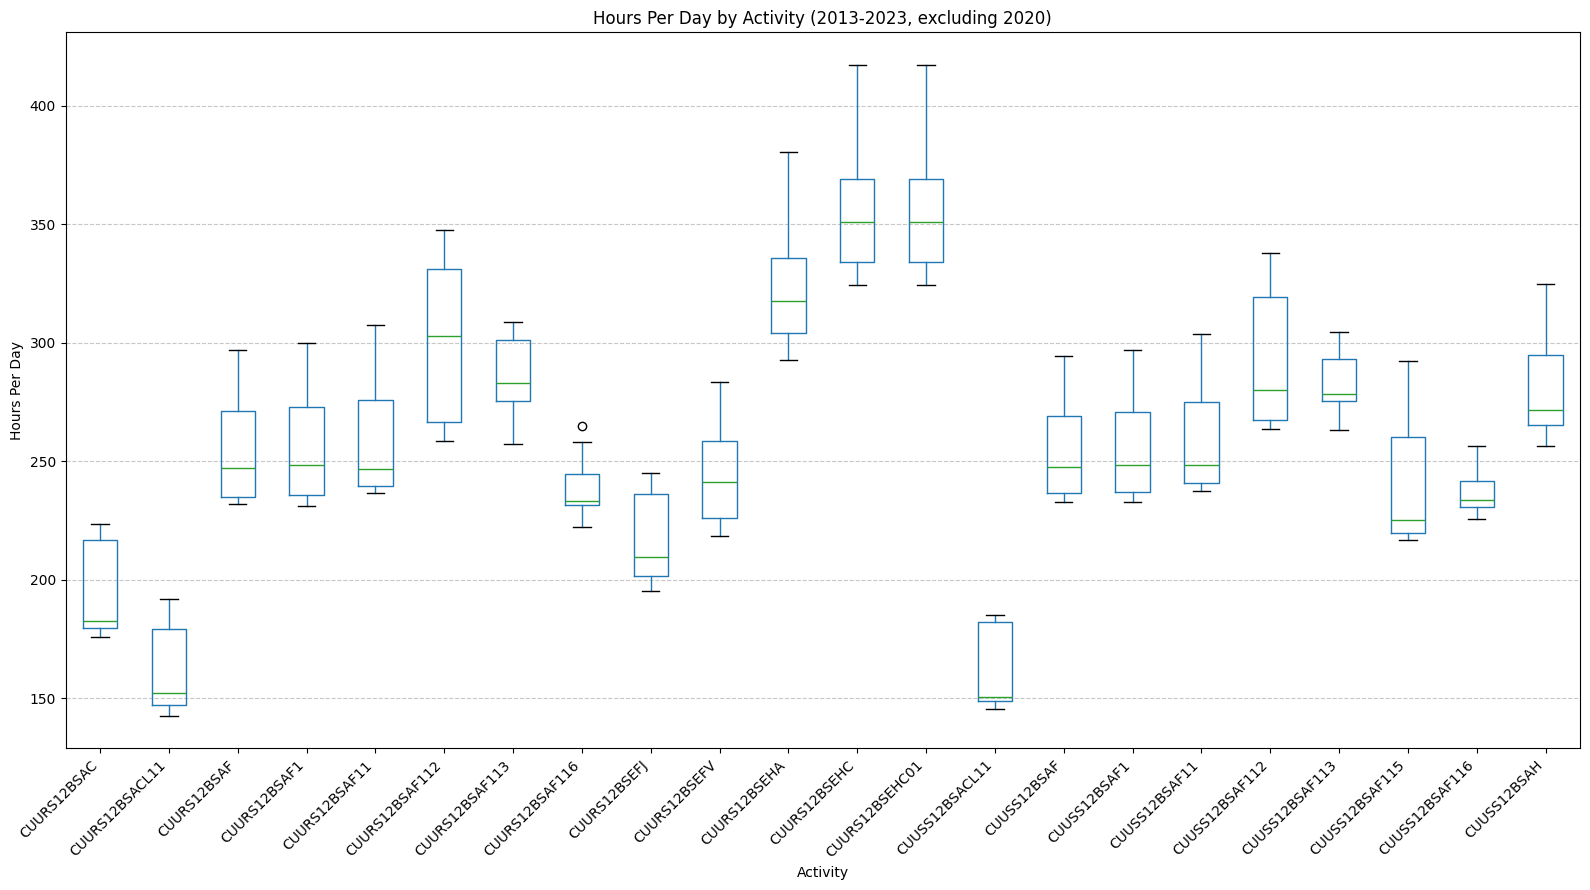

In [8]:
plt.figure(figsize=(16, 9))
df_wide.boxplot(grid=False)
plt.title('Hours Per Day by Activity (2013-2023, excluding 2020)')
plt.xlabel('Activity')
plt.ylabel('Hours Per Day')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

seriesID        CUURS12BSAC  CUURS12BSACL11  CUURS12BSAF  CUURS12BSAF1  \
seriesID                                                                 
CUURS12BSAC        1.000000        0.988116     0.958291      0.957329   
CUURS12BSACL11     0.988116        1.000000     0.903052      0.901656   
CUURS12BSAF        0.958291        0.903052     1.000000      0.999909   
CUURS12BSAF1       0.957329        0.901656     0.999909      1.000000   
CUURS12BSAF11      0.948227        0.890992     0.993528      0.993055   
CUURS12BSAF112     0.957998        0.918616     0.961601      0.960490   
CUURS12BSAF113     0.768724        0.690139     0.855188      0.856956   
CUURS12BSAF116     0.916424        0.876168     0.932578      0.927703   
CUURS12BSEFJ       0.845851        0.759007     0.943612      0.943401   
CUURS12BSEFV       0.940666        0.888137     0.979710      0.980787   
CUURS12BSEHA       0.925235        0.863754     0.980605      0.981627   
CUURS12BSEHC       0.920554        0.8

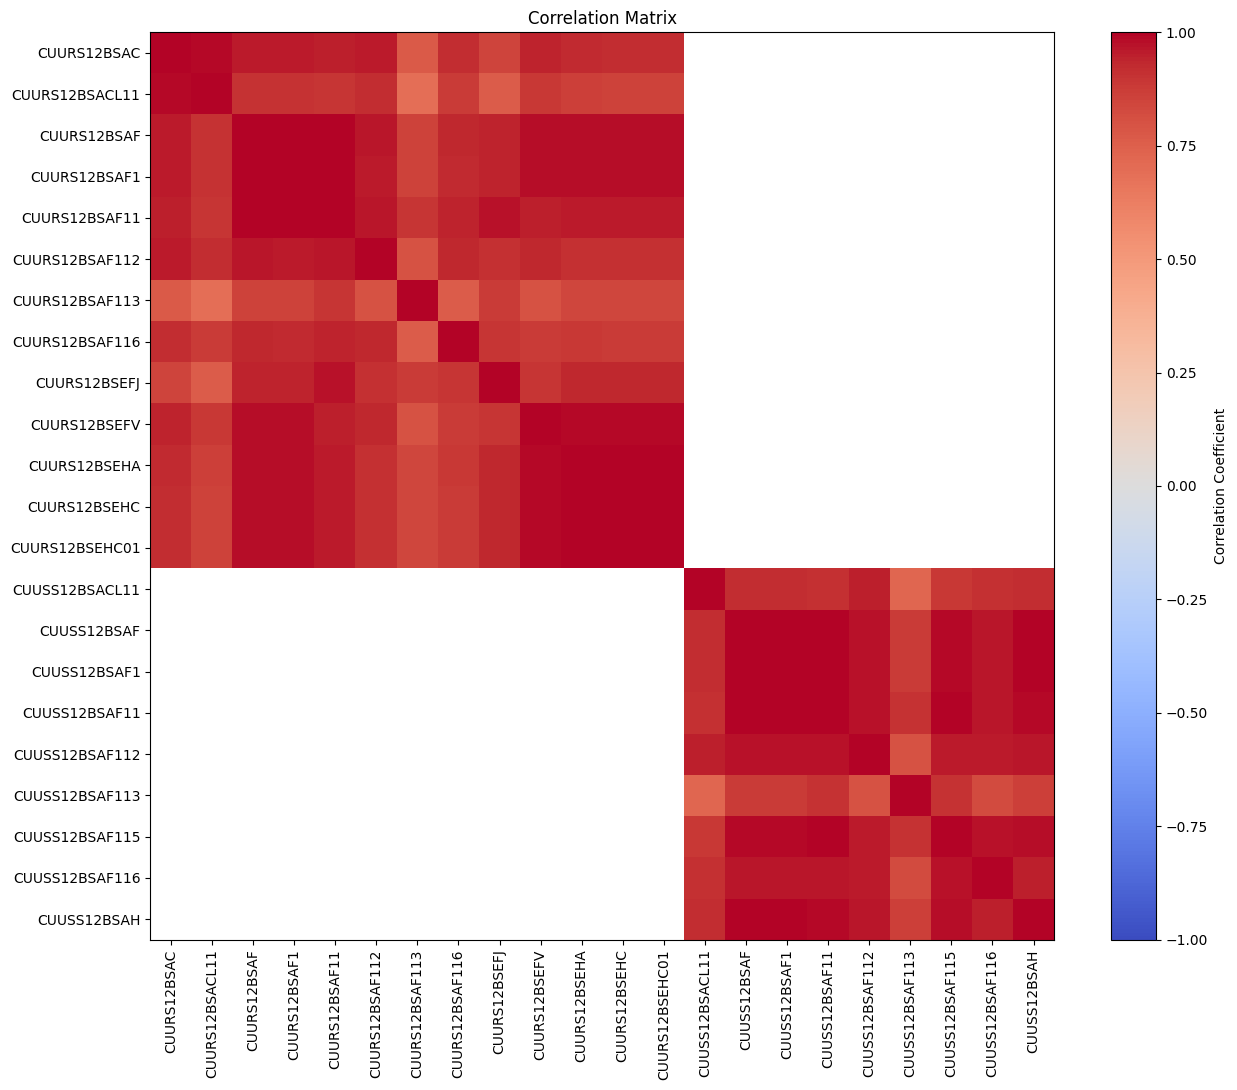

In [9]:
correlation_matrix = df_wide.corr()
print(correlation_matrix)

plt.figure(figsize=(13, 11))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none', vmin=-1, vmax=1, aspect='auto')
plt.colorbar(label='Correlation Coefficient')
plt.xticks(ticks=np.arange(len(correlation_matrix.columns)), labels=correlation_matrix.columns, rotation=90)
plt.yticks(ticks=np.arange(len(correlation_matrix.index)), labels=correlation_matrix.index)
plt.title('Correlation Matrix')

plt.tight_layout()
plt.show()
